# FSGM(Fast Gradient Sign Method) を再現する

In [24]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms.v2 as T
import numpy as np
import matplotlib.pyplot as plt
from models import setup_model


In [2]:
# runtime parameters
MODEL_PATH = './model.pt'
epsilons = [0., .01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .15, .2, .25, .3]
torch.manual_seed(114514)

In [12]:
checkpoint = torch.load(MODEL_PATH, mmap=True)
model = setup_model('mlp3_relu_act')
model.load_state_dict(checkpoint)
model.eval()

/tmp/ipykernel_5803/2728494273.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, mmap=True)


MLP3ReLUAct(
  (ih): Linear(in_features=784, out_features=512, bias=True)
  (ho): Linear(in_features=512, out_features=10, bias=True)
)

In [20]:
# MNIST test dataset
dataset = MNIST(
    root='./.mnist/',
    train=False,
    download=True,
    transform=T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]))
test_loader = DataLoader(
    dataset,
    batch_size=100, shuffle=True)

In [21]:
x, label = next(iter(test_loader))
y_hat, act = model(x)

Text(0, 0.5, 'Frequency')

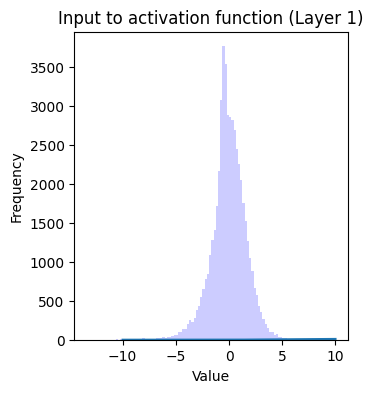

In [37]:
plt.figure(figsize=(12, 4))

x_vals = np.linspace(-10, 10, 1000)


plt.subplot(1, 3, 1)
plt.hist(act.detach().numpy().flatten(), bins=100, color='b', alpha=0.2)
plt.plot(x_vals, F.relu(torch.tensor(x_vals)).detach().numpy())
plt.title('Input to activation function (Layer 1)')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [5]:
# FGSM attack
def fgsm_attack(image, epsilon, image_grad):
    sign_grad = image_grad.sign()
    perturbed_image = image + epsilon*sign_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [6]:
def test(model, test_loader, epsilon):
    # count accuracy
    num_correct = 0
    adv_examples = []

    for data, target in test_loader:
        # input image need to have gradient
        data.requires_grad = True

        # forward pass
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            num_correct += 1
            if epsilon == 0 and len(adv_examples) < 6:
                adv_example = perturbed_data.squeeze().detach().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_example))
        else:
            if len(adv_examples) < 6:
                adv_example = perturbed_data.squeeze().detach().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_example))

    final_accuracy = num_correct / float(len(test_loader))
    print(f'Epsilon: {epsilon}\tTest accuracy = {num_correct} / {len(test_loader)} = {final_accuracy}')

    return final_accuracy, adv_examples
        

In [7]:
accuracies = []
examples = []

for epsilon in epsilons:
    acc, ex = test(model, test_loader, epsilon)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.0	Test accuracy = 9813 / 10000 = 0.9813
Epsilon: 0.01	Test accuracy = 9622 / 10000 = 0.9622
Epsilon: 0.02	Test accuracy = 9246 / 10000 = 0.9246
Epsilon: 0.03	Test accuracy = 8566 / 10000 = 0.8566
Epsilon: 0.04	Test accuracy = 7231 / 10000 = 0.7231
Epsilon: 0.05	Test accuracy = 5559 / 10000 = 0.5559
Epsilon: 0.06	Test accuracy = 4022 / 10000 = 0.4022
Epsilon: 0.07	Test accuracy = 2854 / 10000 = 0.2854
Epsilon: 0.08	Test accuracy = 1964 / 10000 = 0.1964
Epsilon: 0.09	Test accuracy = 1364 / 10000 = 0.1364
Epsilon: 0.1	Test accuracy = 947 / 10000 = 0.0947
Epsilon: 0.15	Test accuracy = 304 / 10000 = 0.0304
Epsilon: 0.2	Test accuracy = 96 / 10000 = 0.0096
Epsilon: 0.25	Test accuracy = 26 / 10000 = 0.0026
Epsilon: 0.3	Test accuracy = 11 / 10000 = 0.0011


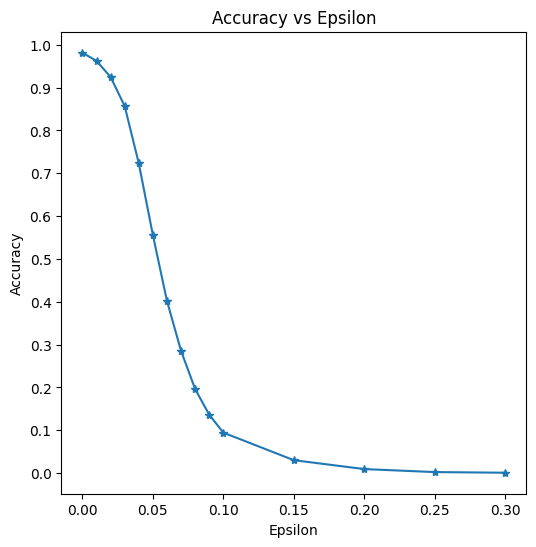

In [10]:
# plot accuracy vs epsilon
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, '*-')
plt.title("Accuracy vs Epsilon")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.savefig('accuracy_vs_epsilon.png')
plt.show()
